# 📨 Spam Classification System
The goal of this notebook is to implement a spam classificator by leveraging an existing large language model.

We will be using the **BERT** model for classification purposes. It was built with the purpose of being useful for multiple tasks by adding an output layer. Some tasks are QA, classification, summarization, etc.

It is an encoder only transformer with non-masked attention (which is where the bidirectional comes from) that generates useful, context dependent representations of the input. It can be thought of as a dynamic embedding algorithm. It was trained on two tasks for pre-training purposes:
- Predict masked token in sequence (inspired by Cloze task)
- Next sentence prediction

Resources:

[Dataset preparation](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-6/v-8/99)

[Hugging Face Fine-tuning guide](https://huggingface.co/docs/transformers/training)

# ⚙️ Requirements Installation

In [ ]:
!pip install tiktoken
!pip install transformers
!pip install evaluate
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00


# 🗃️ Dataset Preparation

## ⬇️ Download Dataset

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

In [ ]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


## 🕵️ Inspecting Dataset

In [ ]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


## ⚖️ Balancing Dataset

In [ ]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

## 🧪 Training, Validation, Test CSVs


In [ ]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)


    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 🪙 Create Tokenized Datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files={"train": "train.csv", "validation": "validation.csv", "test": "test.csv"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Label', 'Text'],
        num_rows: 1045
    })
    validation: Dataset({
        features: ['Label', 'Text'],
        num_rows: 149
    })
    test: Dataset({
        features: ['Label', 'Text'],
        num_rows: 300
    })
})


In [ ]:
print(dataset["train"][100])

{'Label': 0, 'Text': "Hello! How's you and how did saturday go? I was just texting to see if you'd decided to do anything tomo. Not that i'm trying to invite myself or anything!"}


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
print(tokenizer.decode([0])) # special token used for padding

[PAD]


⚠️ Input elements need to have uniform length when training the transformer (sending them into batches). There are two options to deal with variable length elements (such as emails).

1. Use shortest email as a reference and cut longer messages.
2. Pad messages until they reach maximum length in the training corpus.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True)

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1045 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets["validation"][1])

{'Label': 1, 'Text': 'Hungry gay guys feeling hungry and up 4 it, now. Call 08718730555 just 10p/min. To stop texts call 08712460324 (10p/min)', 'input_ids': [101, 26157, 1616, 6463, 3713, 2296, 7555, 1105, 1146, 125, 1122, 117, 1208, 119, 7268, 4775, 1559, 15292, 1559, 13144, 25491, 1571, 1198, 1275, 1643, 120, 11241, 119, 1706, 1831, 6685, 1840, 4775, 1559, 11964, 23435, 1568, 17101, 1527, 113, 1275, 1643, 120, 11241, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 🚚 Create Data Loaders
The data loader combines a dataset with a sampler and provides an iterable over the Dataset object.

In [ ]:
from torch.utils.data import DataLoader

tokenized_datasets = tokenized_datasets.remove_columns(["Text"]) # model does not accept raw text
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels") # required formatting
tokenized_datasets.set_format("torch")

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=8)
val_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=8)

# 🎛️ Model Fine-Tuning
We will be using [BertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification)

In [ ]:
from transformers import AutoModelForSequenceClassification

# The pretrained head of the BERT model is discarded, and replaced with a randomly initialized
# classification head. You will fine-tune this new model head on your sequence classification
# task, transferring the knowledge of the pretrained model to it.
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(f"Model is now using {device}")

Model is now using cuda


In [ ]:
initial_state_dict = {name: param.clone() for name, param in model.named_parameters()}
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 108311810


In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

print(f'For {num_epochs} epochs there will be {num_training_steps} training steps.')

For 3 epochs there will be 393 training steps.


In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

# before fine-tuning
metric.compute()

{'accuracy': 0.5302013422818792}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'epoch: {epoch}, loss: {loss}')

  0%|          | 0/393 [00:00<?, ?it/s]

epoch: 0, loss: 0.03818763792514801
epoch: 1, loss: 1.0136549472808838
epoch: 2, loss: 0.0018679399508982897


In [ ]:
metric = evaluate.load("accuracy")
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

# after fine-tuning
metric.compute()

{'accuracy': 0.9865771812080537}

# 🎮 Playing with Fine-Tuned Model

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# basic interactive prompt to the model
# click enter for classify_text to get triggered

def classify_text(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    inputs.to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    label = "Spam" if prediction == 1 else "Non-Spam"
    return label

def on_submit(sender):
    input_text = text_widget.value
    label = classify_text(input_text)
    output_widget.value = f"Classification: {label}"

text_widget = widgets.Text(
    description="Input Text:",
    layout=widgets.Layout(width='50%')
)

output_widget = widgets.Textarea(
    value='Classification:',
    layout=widgets.Layout(width='50%', height='30px')
)

text_widget.on_submit(on_submit)
display(text_widget, output_widget)

Text(value='', description='Input Text:', layout=Layout(width='50%'))

Textarea(value='Classification:', layout=Layout(height='30px', width='50%'))

# 🧐 Inspecting Changes

In [ ]:
# After fine-tuning, compare named parameters
changed_params = []
for name, param in model.named_parameters():
    if not torch.equal(param, initial_state_dict[name]):
        changed_params.append(name)

In [ ]:
print(f"Number of layers that have changed: {len(changed_params)} out of {len(initial_state_dict.keys())}")
print("Changed layers:", changed_params)

Number of layers that have changed: 201 out of 201
Changed layers: ['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.

In [ ]:
# After fine-tuning, compare the parameters element-wise
changed_param_count = 0
total_param_count = 0

for name, param in model.named_parameters():
    initial_param = initial_state_dict[name]
    total_param_count += param.numel()
    changed_param_count += torch.sum(param != initial_param).item()

print(f"Total number of parameters: {total_param_count}")
print(f"Number of parameters that changed: {changed_param_count}")
print(f"Proportion of parameters that changed: {changed_param_count / total_param_count:.20f}")

Total number of parameters: 108311810
Number of parameters that changed: 108311669
Proportion of parameters that changed: 0.99999869820290143707


In [ ]:
deviation_dict = {}

for name, param in model.named_parameters():
    initial_param = initial_state_dict[name]
    deviation = (param - initial_param).abs()
    deviation_dict[name] = deviation.mean() * 100 # percentage

In [ ]:
avg_deviations = [val.detach().cpu().item() for val in deviation_dict.values()]
print(avg_deviations[100])

0.027277763932943344


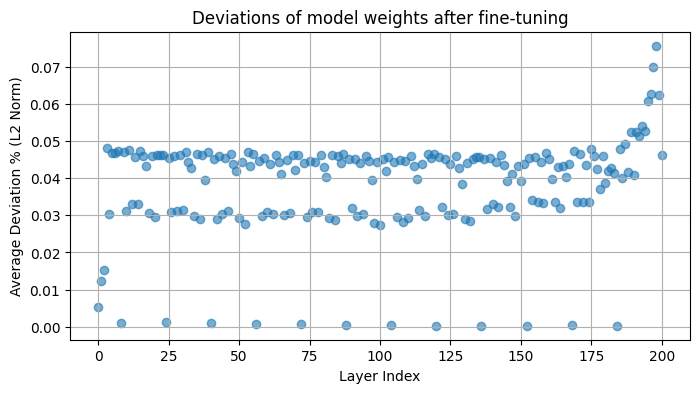

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(range(len(avg_deviations)), avg_deviations, alpha=0.6)
plt.title('Deviations of model weights after fine-tuning')
plt.xlabel('Layer Index')
plt.ylabel('Average Deviation % (L2 Norm)')
plt.grid(True)
plt.show()

Which outcome could be an unintended consequence of fine-tuning❓

Which aspects of the architecture can favor successful fine-tuning❓

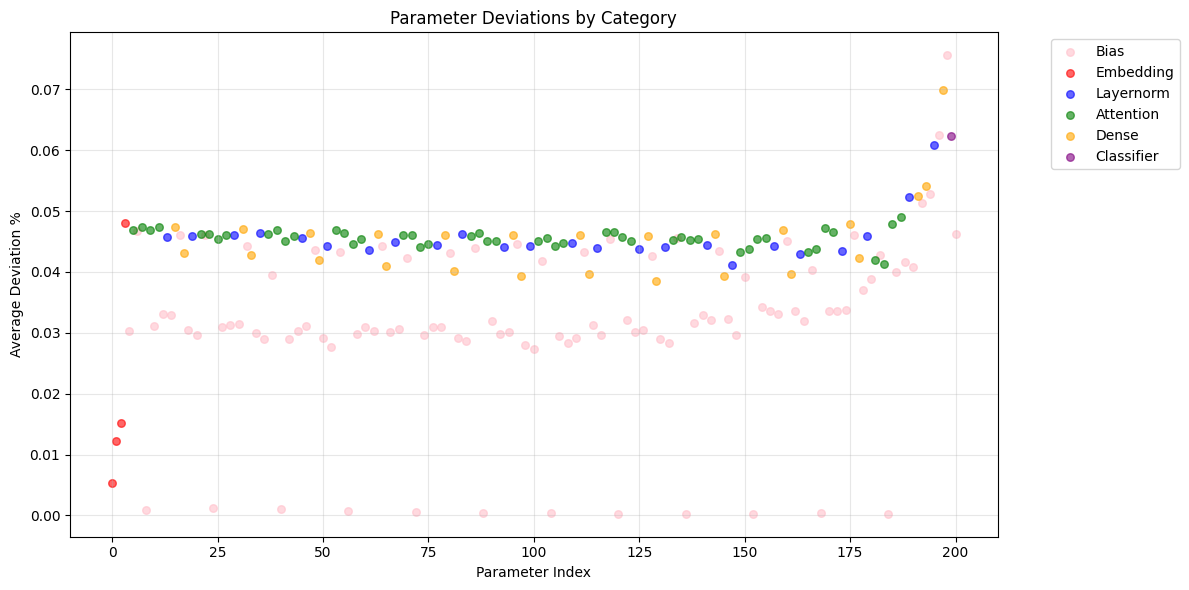

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Categorize parameters
categories = {
    'bias': [],
    'embedding': [],
    'layernorm': [],
    'attention': [],
    'dense': [],
    'classifier': [],
    'other': []
}

def categorize_param(name):
    name_lower = name.lower()
    if 'bias' in name_lower:
        return 'bias'
    elif 'embedding' in name_lower or 'embed' in name_lower:
        return 'embedding'
    elif 'layernorm' in name_lower or 'layer_norm' in name_lower or 'ln' in name_lower:
        return 'layernorm'
    elif 'attention' in name_lower or 'attn' in name_lower or 'self_attn' in name_lower:
        return 'attention'
    elif 'dense' in name_lower or 'linear' in name_lower or 'fc' in name_lower:
        return 'dense'
    elif 'classifier' in name_lower or 'head' in name_lower:
        return 'classifier'
    else:
        return 'other'

# Collect data with category info
plot_data = []
for i, (name, deviation) in enumerate(deviation_dict.items()):
    category = categorize_param(name)
    plot_data.append((i, deviation.detach().cpu().item(), category))

plt.figure(figsize=(12, 6))
colors = {'bias': 'pink', 'embedding': 'red', 'layernorm': 'blue', 'attention': 'green',
          'dense': 'orange', 'classifier': 'purple', 'other': 'brown'}

# Plot each category
for category in categories.keys():
    category_data = [(x, y) for x, y, cat in plot_data if cat == category]
    if category_data:
        x_vals, y_vals = zip(*category_data)
        plt.scatter(x_vals, y_vals, alpha=0.6, label=f'{category.title()}',
                   color=colors[category], s=30)

plt.title('Parameter Deviations by Category')
plt.xlabel('Parameter Index')
plt.ylabel('Average Deviation %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()